# Classification

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Features engineering

-> toutes les données de users
-> mois
-> toutes les triplets d'actions possibles
-> time_elapsed
-> 

In [3]:
# Import data
users = pd.read_csv('data/train_users_2.csv')
test_users = pd.read_csv('data/test_users.csv')
sessions = pd.read_csv('data/sessions.csv')

# Add labels DF/NDF
users['destination_found'] = users.apply(lambda r: 'NDF' if r['country_destination'] == 'NDF' else 'DF', axis=1)

# Retain users that have a session & add information about their session
sessions_naless = sessions.fillna('_')
sessions['action_name'] = sessions_naless['action'] + '-' + sessions_naless['action_type'] + '-' + sessions_naless['action_detail']
users_sessions = sessions.groupby('user_id').agg({
    "action_name": pd.Series.tolist,
    'secs_elapsed': lambda r: round(r.sum() / (60**2), 0),
})
users_sessions = users_sessions.rename({"secs_elapsed":"hours_elapsed", "action_name":"actions",}, axis=1)
users = users_sessions.reset_index().rename({'user_id':'id'}, axis=1).merge(users, how='inner', on='id')

# Make dataset balanced by keeping the smae number users in each classes
n = min(users[users['destination_found'] == 'NDF'].shape[0], users[users['destination_found'] == 'DF'].shape[0])
users = pd.concat([users[users['destination_found'] == 'NDF'].head(n), users[users['destination_found'] == 'DF'].head(n)]).sample(frac=1).reset_index(drop=True)
users = users.sort_values('id')

In [120]:
print("users.head : ", users.shape)
users.tail()

users.head :  (57548, 484)


,id,actions,hours_elapsed,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,...,accept_decline-view-host_respond_page,index-view-view_user_real_names,index-view-view_identity_verifications,index-view-view_ghosting_reasons,show-view-view_identity_verifications,index-view-view_ghostings,deactivated-view-host_standard_suspension,terms--unknown---unknown-,delete-submit-deactivate_user_account,rest-of-world--unknown---unknown-
41025,zzq90ckj2z,"[_-message_post-message_post, pending-booking_...",167.0,2014-04-17,2014-04-17 15:09:26,2014-04-18,-unknown-,-1.0,basic,0,...,0,0,0,0,0,0,0,0,0,0
9287,zzv8sgicbk,"[create-submit-create_user, personalize-data-w...",129.0,2014-02-25,2014-02-25 06:06:28,2014-02-25,MALE,27.0,basic,0,...,0,0,0,0,0,0,0,0,0,0
1384,zzvr84im58,"[authenticate-submit-login, header_userpic-dat...",21.0,2014-03-15,2014-03-15 02:25:07,2014-03-17,MALE,32.0,facebook,12,...,0,0,0,0,0,0,0,0,0,0
13202,zzy7t0y9cm,"[personalize-data-wishlist_content_update, hea...",20.0,2014-03-27,2014-03-27 18:53:45,2014-03-29,-unknown-,-1.0,basic,0,...,0,0,0,0,0,0,0,0,0,0
41949,zzzlylp57e,"[similar_listings-data-similar_listings, show-...",120.0,2014-06-11,2014-06-11 07:46:39,2014-06-24,-unknown-,-1.0,basic,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Converting date string into datetime object
users['timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'], format='%Y%m%d%H%M%S')
users['date_account_created'] = pd.to_datetime(users['date_account_created'], format='%Y-%m-%d')
users["date_first_booking"] = pd.to_datetime(users['date_first_booking'], format='%Y-%m-%d')
users['date_first_active'] = pd.to_datetime(users['timestamp_first_active'].dt.date, format='%Y-%m-%d')
users['hour_first_active'] = users['timestamp_first_active'].dt.hour
users['month_first_active'] = users['date_first_active'].dt.month
users['year_first_active'] = users['date_first_active'].dt.year

In [6]:
def process_age(age):
    if age > 1000:
        return 2015 - age
    elif age < 100:
        return age
    else: 
        return -1

# Bucketize age variable
users['age'] = users.apply(lambda r: process_age(r['age']), axis=1)
users['age_group'] = sum([(users['age'] < 0).astype(int),
    (users['age'] < 18).astype(int),
    (users['age'] < 25).astype(int),
    (users['age'] < 30).astype(int),
    (users['age'] < 35).astype(int),
    (users['age'] < 40).astype(int),
    (users['age'] < 60).astype(int),
    (users['age'] < 100).astype(int)])

In [7]:
def process_signup_flow(num_page):
    if num_page <= 3:
        return num_page
    elif 3 < num_page < 12:
        return 'middle'
    else:
        return 12
    
# Bucketize signup_flow
users['signup_flow_group'] = users.apply(lambda r: process_signup_flow(r['signup_flow']), axis=1)

In [8]:
# Bucketize language
users['language_group'] = (users['language'] == 'en').astype(int)

In [9]:
# Only retains browser which have a large enough set of users
users_browsers = users.groupby('first_browser').count()[['id']].sort_values(by='id')
browsers = set(users_browsers[users_browsers['id'] > 1000].index)
users['first_browser_processed'] = users.apply(lambda r: r['first_browser'] if r['first_browser'] in browsers else 'Other', axis=1)

In [118]:
# Fill Nan in first_affiliate_tracked
users['first_affiliate_tracked'] = users['first_affiliate_tracked'].fillna('-unknown-')

In [80]:
sessions_grouped = sessions[sessions['user_id'].isin(users['id'].values)].groupby('user_id')

In [129]:
action = 'edit-view-edit_profile'
sessions_grouped.agg({'action_name': lambda g: action in g.values}).astype(int)

,action_name
user_id,
00023iyk9l,0
001wyh0pz8,0
0028jgx1x1,0
002qnbzfs5,0
0035hobuyj,0
...,...
zzq90ckj2z,0
zzv8sgicbk,1
zzvr84im58,0


In [108]:
for action in sessions['action_name'].unique():
    users[action] = sessions_grouped.agg({'action_name': lambda g: action in g.values}).astype(int).values

In [128]:
users['edit-view-edit_profile'].sum()

9553

In [112]:
# Selecting features
features = ['month_first_active', 'year_first_active', 'gender', 'age_group', 'signup_method', 'signup_flow_group', 'affiliate_channel', 'affiliate_provider', 
           'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser_processed', 'language_group']

[features.append(action) for action in sessions['action_name'].unique()[:]]

data = users[features].copy()

X = pd.get_dummies(data)
y = users['destination_found'].values
# y = users['country_destination'].values

In [113]:
data.shape

(57548, 470)

## Training model

In [116]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=50, max_depth=16)
res = cross_val_score(model, X=X, y=y)
print(f"Mean score : {np.mean(res)}")
print(f"Std score : {np.std(res)}")

Mean score : 0.7511294669928924
Std score : 0.0014893783098900576


[[0.76672884 0.23327116]
 [0.24910786 0.75089214]]


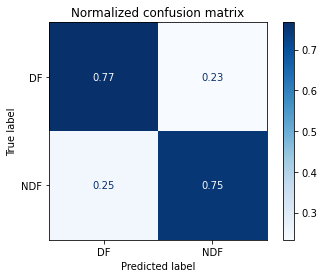

In [49]:
from sklearn.metrics import plot_confusion_matrix
n = int(X.shape[0] * 0.7)
model.fit(X[:n], y[:n])

# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(model, X[n:], y[n:], cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("Normalized confusion matrix")
print(disp.confusion_matrix)